In [1]:
import os
import gym
import random
import numpy as np
import pandas as pd
from itertools import count
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
seed = 1

os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

random.seed(seed)
np.random.seed(seed)

# env.seed(seed)  这个等创建了环境之后再设置

torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [3]:
# hyparameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
training_env_seed = 123
lr = 1e-4   # 可以设成1e-3
gamma = 0.99
is_render = False

# Policy

In [4]:
class Policy(nn.Module):
    def __init__(self, input_shape, action_dim):
        super(Policy, self).__init__()
        
        self.input_shape = input_shape
        self.action_dim = action_dim
        self.affine1 = nn.Linear(self.input_shape, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, self.action_dim)
        

        
    def forward(self, obs):   # obs must be a tensor
        x = self.affine1(obs)
        x = self.dropout(x)
        x = F.relu(x)
        action_logits = self.affine2(x)
        actions = F.softmax(action_logits, dim=-1)
        return actions

# Agent

In [9]:
class REINFORCEAgent(object):
    def __init__(self, env_name=None, policy=Policy, eval_mode=False):
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.env.seed(training_env_seed)
        
        self.obs_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        
        self.policy = policy(self.obs_dim, self.action_dim)
        self.policy.to(device)
        
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        
        self.eval_mode = eval_mode
        
        if self.eval_mode:
            self.policy.eval()
        else:
            self.policy.train()
        
        self.log_probs = []          # 用来记录每个时刻t的log(pi(a_t|s_t))
        self.rewards = []            # 用来记录每个时刻t的reward, r_t
        self.returns = []            # 用来记录每个时刻t的return, G_t
        self.loss = []               # 用来记录每个时刻t的loss: G_t * log(pi(a_t|s_t))
        
        self.eps = np.finfo(np.float32).eps.item()     # 创建一个很小的浮点数，加在分母，防止0的出现，直接写1e-10也行
        
        
    def get_action(self, obs):  # obs is not a tensor
        obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(dim=0)   # [1, obs_dim]
        probs = self.policy(obs)   # 产生策略函数，是一个关于action的概率
        m = Categorical(probs)     # 生成一个Categorical分布，在CartPole里是二项分布
        action = m.sample()        # 从分布里采样，采出的是索引
        self.log_probs.append(m.log_prob(action))  # 把对应的log概率记录下来, 因为后面导数是对logπ（θ）来求的
        
        return action.item()
        
    
    def train(self):
        R = 0
        # policy gradient update
        for r in self.rewards[::-1]:       # 倒序
            R = r + gamma * R              # 计算t到T的reward折现和
            self.returns.insert(0, R)      # 在最前面插入
        
        returns = torch.tensor(self.returns)
        returns = (returns - returns.mean()) / (returns.std() + self.eps)   # 把returns做一个标准化，这样对于action的矫正会更有效果一些，因为一条成功的轨迹里并不一定是所有action都是好的

        for log_prob, R in zip(self.log_probs, returns):
            self.loss.append(-log_prob * R)
            
        self.optimizer.zero_grad()
        loss = torch.cat(self.loss).sum()  # self.loss 是一个列表，里面元素是tensor，然后cat一下, 为了能反向传播梯度？？？
        '''
        这个loss的计算有些trick，我一开始是这么写的
        returns = self.returns
        ...
        loss = torch.tensor(self.loss, requires_grad=True).sum()
        结果return就训不上去，我还没搞明白原因 
        '''
        loss.backward()
        self.optimizer.step()
        
        del self.rewards[:]                        # 把列表清空，但是列表还在，[]
        del self.returns[:]
        del self.log_probs[:]
        del self.loss[:]
        
    
    def eval_(self, env, n_trajs=5):
        self.policy.eval()
        returns = []
        for i in range(n_trajs):
            ep_return = 0
            obs = env.reset()
            for step in range(10000):
                action = self.get_action(obs)
                obs, reward, done, _ =env.step(action)
                ep_return += reward
                
                if done:
                    returns.append(ep_return)
                    break 
        self.policy.train()
        return np.array(returns).mean()
    
    
    def render(self, env):
        self.policy.eval()
        obs = env.reset()
        for _ in range(10000):
            env.render()
            action = self.get_action(obs)
            obs, reward, done, _ = env.step(action)
            if done:
                break
        self.policy.train()
        
        
    def save(self, step):
        torch.save(self.policy.state_dict(), './reinforce_{}.pt'.format(step))
        
    def load(self, path):
        if os.path.isfile(path):
            self.policy.load_state_dict(torch.load(path))
            # self.policy.load_state_dict(torch.load(path), map_location=lambda storage, loc: storage))  # 在gpu上训练，load到cpu上的时候可能会用到
        else:
            print('No "{}" exits for loading'.format(path))

# Training Loop

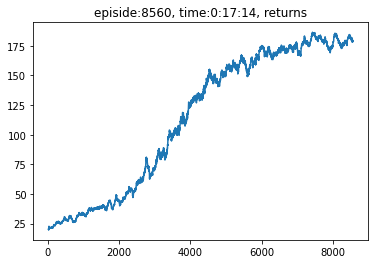

Solved! eval return is now 195.61!


In [13]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


start = timer()
running_returns = []
agent_reinforce = REINFORCEAgent(env_name=name, policy=Policy)

for episode in count(1): # 一直加1的while, 表示一条episode
    # print('episode%d'%episode)
    obs, ep_return = agent_reinforce.env.reset(), 0
    for step in range(10000):
        action = agent_reinforce.get_action(obs)
        obs, reward, done, _ = agent_reinforce.env.step(action)
        agent_reinforce.rewards.append(reward)
        ep_return += reward
        if done:
            running_returns.append(ep_return)
            break
    
    agent_reinforce.train()
    
    
    if episode % 10 == 0:
        clear_output(True)
        plt.plot(pd.Series(running_returns).rolling(100, 20).mean())
        plt.title('episide:{}, time:{}, returns'.format(episode, timedelta(seconds=int(timer()-start))))
        plt.show()
    if np.array(running_returns)[-10:].mean() > 195:
        eval_return = agent_reinforce.eval_(env_eval, 100)
        if eval_return > 195:
            print("Solved! eval return is now {}!".format(eval_return))
            break 

In [20]:
eval_return = agent_reinforce.eval_(env_eval, 100)
print(eval_return)

191.71


In [16]:
agent_reinforce.render(env_eval)

In [17]:
torch.save(agent_reinforce.policy.state_dict(), './reinforce_cartpole.pt')